# Store Item Demand Forecasting

**Description**

This competition is provided as a way to explore different time series techniques on a relatively simple and clean dataset.

You are given 5 years of store-item sales data, and asked for the sales for 50 different items at 10 different stores.

What's the best way to deal with seasonality? Should stores be modeled separately, or can you pool them together? Which algorithms are best for handling a time-series dataset?

**Evaluation**

Submissions are evaluated on [SMAPE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error) between forecasts and actual values. We define [SMAPE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error) = 0 when the actual and predicted values are both 0.

**Variables:**
- date
- store
- item
- sales

# Packages

In [51]:
# Base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Model
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Data

In [52]:
train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])
df = pd.concat([train, test], sort=False)

print(train.shape, test.shape, df.shape, "\n")
train.head()

(913000, 4) (45000, 4) (958000, 5) 



,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


# Exploratory Data Analysis

In [53]:
# How many stores and items are there?
train.store.nunique(), test.store.nunique(), train.item.nunique(), test.item.nunique()

(10, 10, 50, 50)

In [54]:
# Time Range
train["date"].min(), train["date"].max(), test["date"].min(), test["date"].max()

(Timestamp('2013-01-01 00:00:00'),
 Timestamp('2017-12-31 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-03-31 00:00:00'))

We can see that the `train` dataset spans 5 years while the `test` dataset spans 3 months.

In [55]:
# How many items are in the store?
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [56]:
# Summary Stats for each store
df.groupby(["store"]).agg({"sales": ["sum", "mean", "median", "std", "min", "max"]})

sales                                         
             sum       mean median        std  min    max
store                                                    
1      4315603.0  47.268379   44.0  24.006252  1.0  155.0
2      6120128.0  67.033165   62.0  33.595810  3.0  231.0
3      5435144.0  59.530602   55.0  29.974102  3.0  196.0
4      5012639.0  54.902946   51.0  27.733097  4.0  186.0
5      3631016.0  39.770164   37.0  20.365757  2.0  130.0
6      3627670.0  39.733516   37.0  20.310451  0.0  134.0
7      3320009.0  36.363735   34.0  18.684825  1.0  122.0
8      5856169.0  64.142048   60.0  32.231751  4.0  204.0
9      5025976.0  55.049025   51.0  27.832186  4.0  195.0
10     5360158.0  58.709288   54.0  29.554994  3.0  187.0

In [57]:
# Missing Value Analysis
print("##################### NA #####################")
print(train.isnull().sum())

##################### NA #####################
date     0
store    0
item     0
sales    0
dtype: int64


No missing values in the `train` dataset.

### Check for Outliers

In [58]:
def outlier_thresholds(dataframe, col_name, q1_perc=0.05, q3_perc=0.95):
    """
    given dataframe, column name, q1_percentage and q3 percentage, function calculates low_limit and up_limit

    """
    quartile1 = dataframe[col_name].quantile(q1_perc)
    quartile3 = dataframe[col_name].quantile(q3_perc)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name, q1_perc=0.01, q3_perc=0.99):
    outlier_list = []
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1_perc=0.01, q3_perc=0.99)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True

    else:
        return False

In [59]:
check_outlier(df, 'sales')

False

No outliers in the sales column.

In [60]:
# Summary Stats for each item
df.groupby(["item"]).agg({"sales": ["sum", "mean", "median", "std", "min", "max"]})

sales                                          
            sum       mean median        std   min    max
item                                                     
1      401384.0  21.981599   21.0   8.468922   1.0   59.0
2     1069564.0  58.574151   56.0  20.093015   9.0  150.0
3      669087.0  36.642223   35.0  13.179441   7.0  104.0
4      401907.0  22.010241   21.0   8.403898   0.0   66.0
5      335230.0  18.358708   18.0   7.265167   1.0   50.0
6     1068281.0  58.503888   56.0  20.174898  11.0  148.0
7     1068777.0  58.531051   56.0  20.146002  11.0  141.0
8     1405108.0  76.950055   74.0  26.130697  15.0  181.0
9      938379.0  51.389869   49.5  17.790158   6.0  134.0
10    1337133.0  73.227437   70.0  24.823725  14.0  175.0
11    1271925.0  69.656353   67.0  23.744732  11.0  170.0
12    1271534.0  69.634940   67.0  23.738663  12.0  170.0
13    1539621.0  84.316594   81.0  28.311031  20.0  210.0
14    1071531.0  58.681873   56.0  20.079860  12.0  152.0
15    1607442.0  88.030778   85.0  29.522852  17.0  231.0
16     468480.0  25.656079   25.0   9.603270   2.0   70.0
17     602486.0  32.994852   32.0  11.967610   4.0   83.0
18    1538876.0  84.275794   81.0  28.430621  18.0  208.0
19     736892.0  40.355531   39.0  14.332645   5.0   99.0
20     867641.0  47.515936   46.0  16.490487   9.0  127.0
21     736190.0  40.317087   39.0  14.338006   7.0  109.0
22    1469971.0  80.502245   78.0  27.118163  14.0  214.0
23     534979.0  29.297864   28.0  10.819549   3.0   81.0
24    1205975.0  66.044633   64.0  22.531555  14.0  156.0
25    1473334.0  80.686418   78.0  27.238817  18.0  193.0
26     869981.0  47.644085   46.0  16.723912   8.0  119.0
27     402628.0  22.049726   21.0   8.461641   1.0   59.0
28    1604713.0  87.881325   85.0  29.501781  16.0  206.0
29    1271240.0  69.618839   67.0  23.635631  15.0  173.0
30     736554.0  40.337021   39.0  14.363331   5.0  115.0
31    1070845.0  58.644304   57.0  20.104705  10.0  159.0
32     803107.0  43.981763   42.0  15.574556   5.0  119.0
33    1270183.0  69.560953   67.0  23.718343  15.0  169.0
34     469935.0  25.735761   25.0   9.617910   2.0   79.0
35    1201541.0  65.801807   63.0  22.461990  12.0  168.0
36    1406548.0  77.028916   74.0  26.067440  16.0  188.0
37     534258.0  29.258379   28.0  10.771547   3.0   74.0
38    1470330.0  80.521906   77.0  27.141799  15.0  188.0
39     801311.0  43.883406   42.0  15.511550   7.0  112.0
40     534094.0  29.249398   28.0  10.822959   3.0   74.0
41     401759.0  22.002136   21.0   8.402470   2.0   60.0
42     669925.0  36.688116   35.0  13.215112   5.0   96.0
43     936635.0  51.294359   49.0  17.801008   9.0  126.0
44     536811.0  29.398193   28.0  10.797738   3.0   78.0
45    1471467.0  80.584173   78.0  27.318402  18.0  205.0
46    1070764.0  58.639869   56.0  20.220879  11.0  150.0
47     401781.0  22.003341   21.0   8.420102   2.0   61.0
48     937703.0  51.352848   49.0  17.881917   8.0  130.0
49     535663.0  29.335323   28.0  10.874788   3.0   77.0
50    1203009.0  65.882202   63.0  22.416031  12.0  164.0

#### Histogram: Store Sales

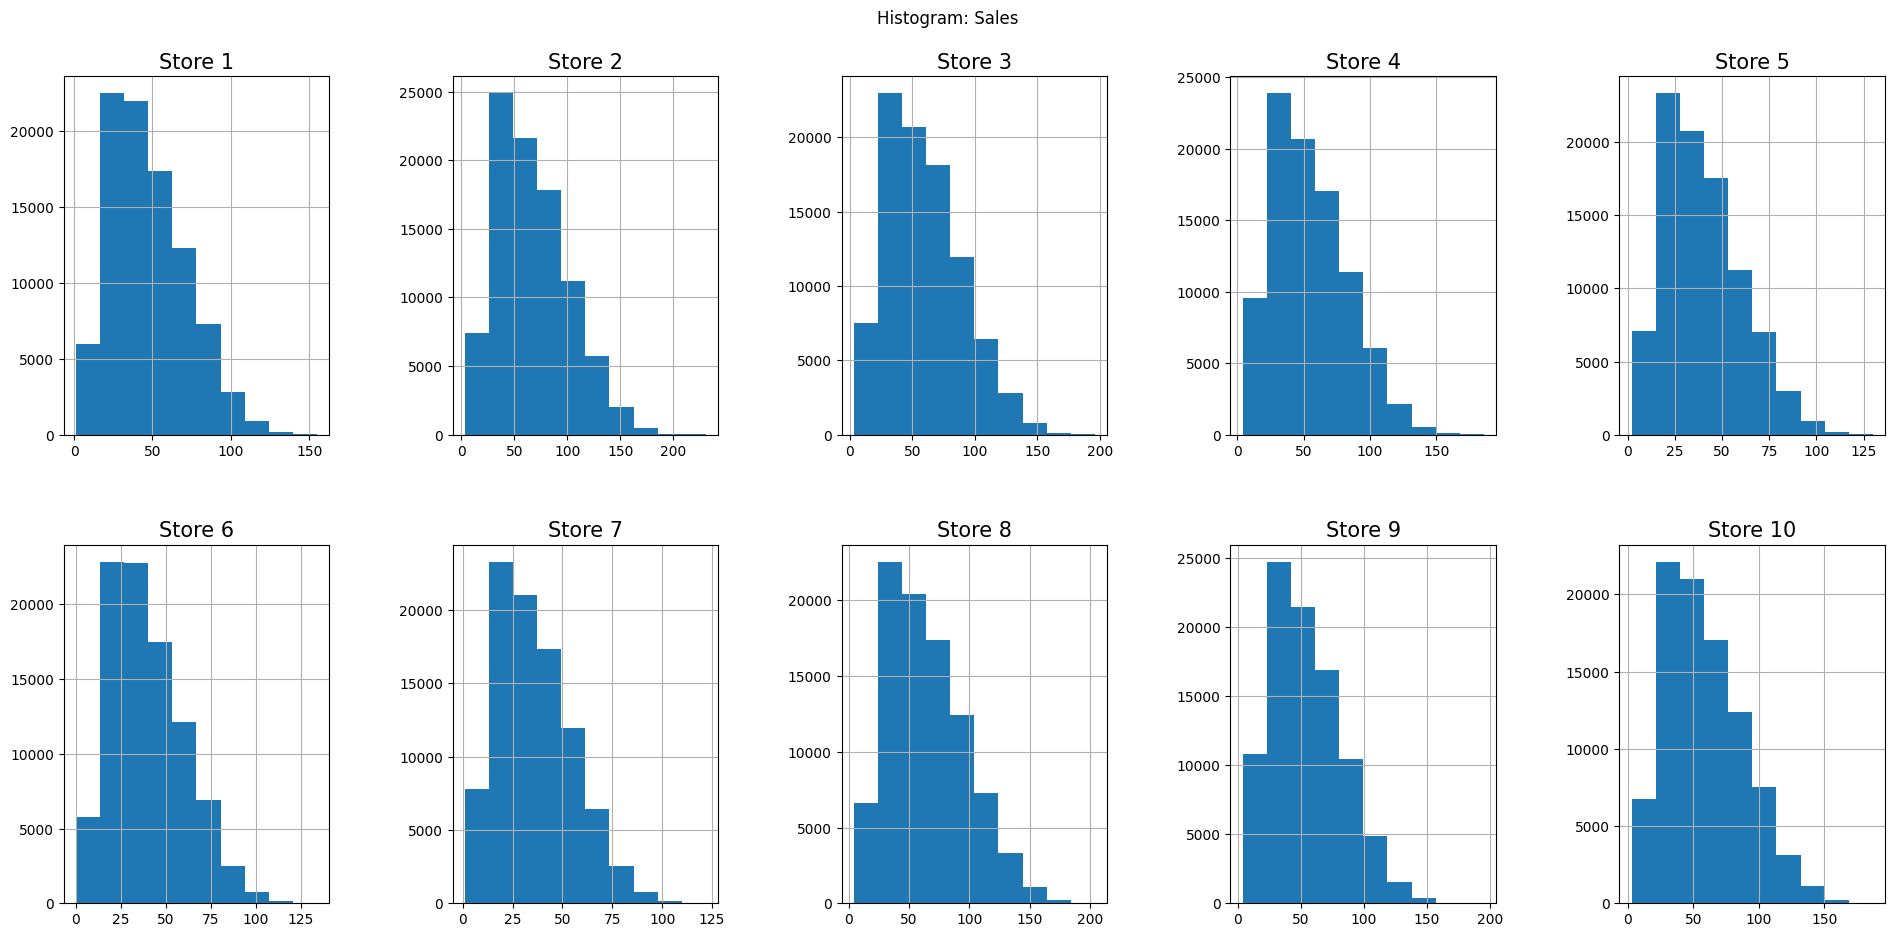

In [61]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i in range(1,11):
    if i < 6:
        train[train.store == i].sales.hist(ax=axes[0, i-1])
        axes[0,i-1].set_title("Store " + str(i), fontsize = 15)
        
    else:
        train[train.store == i].sales.hist(ax=axes[1, i - 6])
        axes[1,i-6].set_title("Store " + str(i), fontsize = 15)
plt.tight_layout(pad=4.5)
plt.suptitle("Histogram: Sales");

Bivariate analysis of the `sales` column with respect to the `store` column.

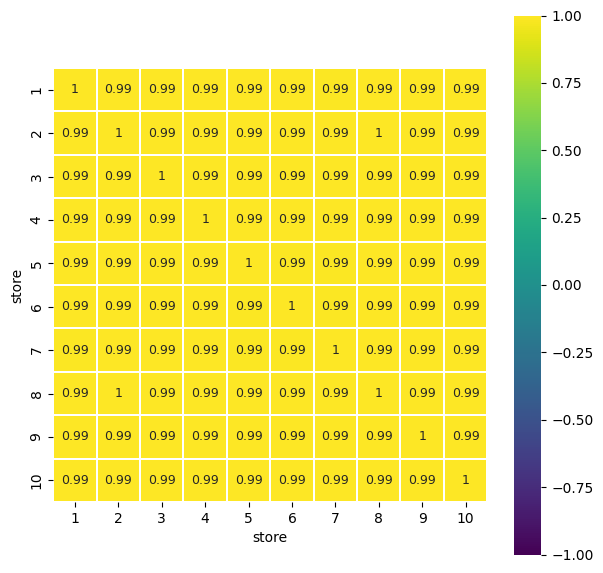

In [62]:
storesales = train.groupby(["date", "store"]).sales.sum().reset_index().set_index("date")
corr =  pd.pivot_table(storesales, values = "sales", columns="store", index="date").corr(method = "spearman")
plt.figure(figsize = (7,7))
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.5)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 9}, square=True);

Check for Multicolinearity

In [63]:
df.corr(method='pearson').style.background_gradient(cmap='rocket_r')

,store,item,sales,id
store,1.000000,0.000000,-0.008170,0.019900
item,0.000000,1.000000,-0.055998,0.999800
sales,-0.008170,-0.055998,1.000000,nan
id,0.019900,0.999800,nan,1.000000


We can see that no two features in the `dataframe` are highly correlated.

#### Hypothesis Testing

##### Stores

In [64]:
# T Test
def CompareTwoGroups(dataframe, group, target):
    
    import itertools
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # 1. Normality Test: Shapiro Test
    # 2. Homogeneity Test: Levene Test
    # 3. Parametric or Non-Parametric T Test: T-Test, Welch Test, Mann Whitney U
    
    # Create Combinations
    item_comb = list(itertools.combinations(dataframe[group].unique(), 2))
    
    AB = pd.DataFrame()
    for i in range(0, len(item_comb)):
        # Define Groups
        groupA = dataframe[dataframe[group] == item_comb[i][0]][target]
        groupB = dataframe[dataframe[group] == item_comb[i][1]][target]
        
        # Assumption: Normality
        ntA = shapiro(groupA)[1] < 0.05
        ntB = shapiro(groupB)[1] < 0.05
        # H0: Distribution is Normal! - False
        # H1: Distribution is not Normal! - True
        
        if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
            # Parametric Test
            # Assumption: Homogeneity of variances
            leveneTest = stats.levene(groupA, groupB)[1] < 0.05
            # H0: Homogeneity: False
            # H1: Heterogeneous: True
            if leveneTest == False:
                # Homogeneity
                ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
                # H0: M1 = M2 - False
                # H1: M1 != M2 - True
            else:
                # Heterogeneous
                ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
                # H0: M1 = M2 - False
                # H1: M1 != M2 - True
        else:
            # Non-Parametric Test
            ttest = stats.mannwhitneyu(groupA, groupB)[1] 
            # H0: M1 = M2 - False
            # H1: M1 != M2 - True
            
        temp = pd.DataFrame({"Compare Two Groups":[ttest < 0.05], 
                             "p-value":[ttest],
                             "GroupA_Mean":[groupA.mean()], "GroupB_Mean":[groupB.mean()],
                             "GroupA_Median":[groupA.median()], "GroupB_Median":[groupB.median()],
                             "GroupA_Count":[groupA.count()], "GroupB_Count":[groupB.count()]
                            }, index = [item_comb[i]])
        temp["Compare Two Groups"] = np.where(temp["Compare Two Groups"] == True, "Different Groups", "Similar Groups")
        temp["TestType"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
        
        AB = pd.concat([AB, temp[["TestType", "Compare Two Groups", "p-value","GroupA_Median", "GroupB_Median","GroupA_Mean", "GroupB_Mean",
                                 "GroupA_Count", "GroupB_Count"]]])
        
    return AB
    
    
CompareTwoGroups(storesales, group = "store", target = "sales")

,TestType,Compare Two Groups,p-value,GroupA_Median,GroupB_Median,GroupA_Mean,GroupB_Mean,GroupA_Count,GroupB_Count
"(1, 2)",Non-Parametric,Different Groups,1.142171e-261,2339.5,3310.5,2363.418949,3351.658269,1826,1826
"(1, 3)",Non-Parametric,Different Groups,9.986606e-135,2339.5,2937.5,2363.418949,2976.530120,1826,1826
"(1, 4)",Non-Parametric,Different Groups,4.089808e-62,2339.5,2708.0,2363.418949,2745.147317,1826,1826
"(1, 5)",Non-Parametric,Different Groups,1.482497e-80,2339.5,1970.5,2363.418949,1988.508215,1826,1826
"(1, 6)",Non-Parametric,Different Groups,1.322467e-81,2339.5,1963.0,2363.418949,1986.675794,1826,1826
"(1, 7)",Non-Parametric,Different Groups,4.984442e-167,2339.5,1796.5,2363.418949,1818.186747,1826,1826
"(1, 8)",Non-Parametric,Different Groups,2.806842e-213,2339.5,3174.5,2363.418949,3207.102410,1826,1826
"(1, 9)",Non-Parametric,Different Groups,6.988553e-64,2339.5,2719.5,2363.418949,2752.451260,1826,1826
"(1, 10)",Non-Parametric,Different Groups,7.007060e-121,2339.5,2899.0,2363.418949,2935.464403,1826,1826
"(2, 3)",Non-Parametric,Different Groups,1.634782e-40,3310.5,2937.5,3351.658269,2976.530120,1826,1826


##### Items

In [65]:
itemsales = train.groupby(["date", "item"]).sales.sum().reset_index().set_index("date")
ctg_is = CompareTwoGroups(itemsales, group = "item", target = "sales")
ctg_is[ctg_is["Compare Two Groups"] == "Similar Groups"]

,TestType,Compare Two Groups,p-value,GroupA_Median,GroupB_Median,GroupA_Mean,GroupB_Mean,GroupA_Count,GroupB_Count
"(1, 4)",Non-Parametric,Similar Groups,0.842383,218.0,218.0,219.815991,220.102410,1826,1826
"(1, 27)",Non-Parametric,Similar Groups,0.746252,218.0,218.0,219.815991,220.497262,1826,1826
"(1, 41)",Non-Parametric,Similar Groups,0.961622,218.0,218.0,219.815991,220.021358,1826,1826
"(1, 47)",Non-Parametric,Similar Groups,0.946145,218.0,217.0,219.815991,220.033406,1826,1826
"(2, 6)",Non-Parametric,Similar Groups,0.899452,578.0,578.5,585.741512,585.038883,1826,1826
...,...,...,...,...,...,...,...,...,...
"(40, 44)",Non-Parametric,Similar Groups,0.489586,289.0,291.0,292.493976,293.981928,1826,1826
"(40, 49)",Non-Parametric,Similar Groups,0.769478,289.0,289.0,292.493976,293.353231,1826,1826
"(41, 47)",Non-Parametric,Similar Groups,0.993689,218.0,217.0,220.021358,220.033406,1826,1826
"(43, 48)",Non-Parametric,Similar Groups,0.902335,508.5,506.0,512.943593,513.528478,1826,1826


In [66]:
df = df.sort_values("date").reset_index(drop = True)
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
df['is_month_end'] = df.date.dt.is_month_end.astype(int)
df['is_quarter_start'] = df.date.dt.is_quarter_start.astype(int)
# Train Validation Split
# Validation set includes 3 months (Oct. Nov. Dec. 2017)
train = df.loc[(df["date"] < "2017-10-01"), :]
val = df.loc[(df["date"] >= "2017-10-01") & (df["date"] < "2018-01-01"), :]


cols = [col for col in train.columns if col not in ["sales"]]
base_train = train
base_test = test
base_Y_train = train['sales']
base_X_train = train[cols]

base_Y_val = val['sales']
base_X_val = val[cols]

base_Y_train.shape, base_X_train.shape, base_Y_val.shape, base_X_val.shape

((867000,), (867000, 7), (46000,), (46000, 7))

# Feature Engineering

- Time Related Features
- Lagged Features
- Moving Average Features
- Hypothesis Testing: Similarity Features
- Exponentially Weighted Mean Features

In [67]:
# 1. Time Related Features
#####################################################
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek + 1
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df["quarter"] = df.date.dt.quarter
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    df['is_quarter_start'] = df.date.dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df.date.dt.is_quarter_end.astype(int)
    df['is_year_start'] = df.date.dt.is_year_start.astype(int)
    df['is_year_end'] = df.date.dt.is_year_end.astype(int)
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = np.where(df.month.isin([9, 10, 11]), 3, df["season"])
    return df
df = create_date_features(df)


# Rolling Summary Stats Features
#####################################################
for i in [91, 98, 105, 112, 119, 126, 186, 200, 210, 250, 300, 365, 546, 700]:
    df["sales_roll_mean_"+str(i)]=df.groupby(["store", "item"]).sales.rolling(i).mean().shift(1).values

# 2. Hypothesis Testing: Similarity
#####################################################

# Store Based
storesales = train.groupby(["date", "store"]).sales.sum().reset_index()
ctg_ss = CompareTwoGroups(storesales, group="store", target="sales")
del storesales

df["StoreSalesSimilarity"] = np.where(df.store.isin([3,10]), 1, 0)
df["StoreSalesSimilarity"] = np.where(df.store.isin([4,9]), 2, df["StoreSalesSimilarity"])
df["StoreSalesSimilarity"] = np.where(df.store.isin([5,6]), 3, df["StoreSalesSimilarity"])

# Item Based

itemsales = train.groupby(["date", "item"]).sales.sum().reset_index()
ctg_is = CompareTwoGroups(itemsales, group = "item", target = "sales")
del itemsales

df["ItemSalesSimilarity"] = np.where(df.item.isin([1,4,27,41,47]), 1, 0)
df["ItemSalesSimilarity"] = np.where(df.item.isin([2,6,7,14,31,46]), 2, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([3,42]), 3, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([8,36]), 4, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([9,43,48]), 5, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([11,12,29,33]), 6, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([13,18]), 7, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([15,28]), 8, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([16,34]), 9, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([19,21,30]), 10, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([20,26]), 11, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([22,25,38,45]), 12, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([23,37,40,44,49]), 13, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([24,35,50]), 14, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([32,39]), 15, df["ItemSalesSimilarity"])

# 3. Lag/Shifted Features
#####################################################

# test.groupby(["store", "item"]).date.count()

df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

def lag_features(dataframe, lags, groups = ["store", "item"], target = "sales", prefix = ''):
    dataframe = dataframe.copy()
    for lag in lags:
        dataframe[prefix + str(lag)] = dataframe.groupby(groups)[target].transform(
            lambda x: x.shift(lag))
    return dataframe

df = lag_features(df, lags = [91, 92,93,94,95,96, 97, 98, 100, 105, 112, 119, 126, 150,
                              182,200,220, 250, 300, 350, 355, 360,361,362,363, 364,
                              365, 370, 375,380, 546, 600, 650, 680, 690, 700, 710, 728,
                              730, 800, 900, 950, 990, 1000, 1050, 1090, 1095],
                  groups = ["store", "item"], target = 'sales', prefix = 'sales_lag_')

def drop_cor(dataframe, name, index):
    ind = dataframe[dataframe.columns[dataframe.columns.str.contains(name)].tolist()+["sales"]].corr().sales.sort_values(ascending = False).index[1:index]
    ind = dataframe.drop(ind, axis = 1).columns[dataframe.drop(ind, axis = 1).columns.str.contains(name)]
    dataframe.drop(ind, axis = 1, inplace = True)

drop_cor(df, "sales_lag", 16)

# pd.cut
clus = df.groupby(["store"]).sales.mean().reset_index()
clus["store_cluster"] =  pd.cut(clus.sales, bins = 4, labels = range(1,5))
clus.drop("sales", axis = 1, inplace = True)
df = pd.merge(df, clus, how = "left")
clus = df.groupby(["item"]).sales.mean().reset_index()
clus["item_cluster"] =  pd.cut(clus.sales, bins = 5, labels = range(1,6))
clus.drop("sales", axis = 1, inplace = True)
df = pd.merge(df, clus, how = "left")
del clus

df.shape

(958000, 53)

# Train-Validation Split

In [68]:
# Dataframe must be sorted by date because of Time Series Split 
df = df.sort_values("date").reset_index(drop = True)

# Train Validation Split
# Validation set includes 3 months (Oct. Nov. Dec. 2017)
train = df.loc[(df["date"] < "2017-10-01"), :]
val = df.loc[(df["date"] >= "2017-10-01") & (df["date"] < "2018-01-01"), :]


cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((867000,), (867000, 49), (46000,), (46000, 49))

# Custom Cost Function

If you want to see the SMAPE formula, click [here](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error).

In [69]:
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(y_true, y_pred):
    smape_val = smape(y_true, y_pred)
    return 'SMAPE', smape_val, False

def xgb_smape(y_pred, y_true):
    smape_val = smape(y_true, y_pred)
    return 'SMAPE', smape_val, False


# Base Model

In [70]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# Impute missing values with the mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_imputed = imp.fit_transform(X_train)
X_val_imputed = imp.transform(X_val)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=30, max_depth=8, n_jobs=-1, random_state=384)
rf_model.fit(X_train_imputed, Y_train)

# Evaluate the model on the training and validation sets
print("TRAIN SMAPE:", smape(Y_train, rf_model.predict(X_train_imputed)))
print("VALID SMAPE:", smape(Y_val, rf_model.predict(X_val_imputed)))


TRAIN SMAPE: 15.981324332847525
VALID SMAPE: 14.742087217284634


## Choosing the best Model

In [71]:
from catboost import CatBoostRegressor

cat_features = ['store_cluster', 'item_cluster', 'store', 'item']
cat_model = CatBoostRegressor(random_state=384, cat_features=cat_features, verbose=30, iterations=150)
cat_model.fit(X_train, Y_train, eval_set=(X_val, Y_val))

print("TRAIN SMAPE:", smape(Y_train, cat_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, cat_model.predict(X_val)))

Learning rate set to 0.468543
0:	learn: 19.9850173	test: 18.0278246	best: 18.0278246 (0)	total: 173ms	remaining: 25.7s
30:	learn: 7.6932883	test: 7.9377091	best: 7.9377091 (30)	total: 4.42s	remaining: 17s
60:	learn: 7.4640695	test: 7.7374517	best: 7.7374517 (60)	total: 8.59s	remaining: 12.5s
90:	learn: 7.3823916	test: 7.6696884	best: 7.6696884 (90)	total: 12.7s	remaining: 8.25s
120:	learn: 7.3372782	test: 7.6316308	best: 7.6316308 (120)	total: 17.1s	remaining: 4.09s
149:	learn: 7.3092588	test: 7.6219117	best: 7.6217817 (148)	total: 21.2s	remaining: 0us

bestTest = 7.621781737
bestIteration = 148

Shrink model to first 149 iterations.
TRAIN SMAPE: 12.707056193904979
VALID SMAPE: 12.377364142207327


In [72]:
import xgboost as xgb

X_train_encoded = pd.get_dummies(X_train, columns=["store_cluster", "item_cluster"])
X_val_encoded = pd.get_dummies(X_val, columns=["store_cluster", "item_cluster"])
xgb_reg = xgb.XGBRegressor(random_state=384)
xgb_reg.fit(X_train_encoded, Y_train)

print("TRAIN SMAPE:", smape(Y_train, xgb_reg.predict(X_train_encoded)))
print("VALID SMAPE:", smape(Y_val, xgb_reg.predict(X_val_encoded)))

TRAIN SMAPE: 12.884818689985188
VALID SMAPE: 12.903162461515096


In [73]:

first_model = lgb.LGBMRegressor(random_state=384, num_leaves=31, n_estimators=700, max_depth=10, metric = "custom").fit(X_train, Y_train, 
                                                      eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model.predict(X_val)))

TRAIN SMAPE: 12.619422356828126
VALID SMAPE: 12.531113914921988


We choose the `LightGBM` model since it produces the best score.

# Feature Importance

In [74]:

def plot_lgb_importances(model, plot=False, num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns
    
    # Generating gain feature importance
    gain = model.booster_.feature_importance(importance_type='gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name_,
                            'split': model.booster_.feature_importance(importance_type='split'),
                            'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(first_model, num=50)

                 feature  split       gain
38         sales_lag_364   2083  51.715349
32         sales_lag_350   1389  19.190763
48          item_cluster   1294  13.999773
47         store_cluster    801   2.463749
15                season    500   1.997621
9            day_of_week    860   1.727268
40         sales_lag_370    662   1.401926
43         sales_lag_728   1217   1.314756
37         sales_lag_363    629   1.232494
39         sales_lag_365   1023   1.161412
41         sales_lag_380    523   0.752308
36         sales_lag_362    501   0.544042
31   ItemSalesSimilarity   1038   0.413773
5                  month    617   0.371245
8           week_of_year    214   0.351155
42         sales_lag_700    573   0.210725
7            day_of_year    809   0.205253
44         sales_lag_730    614   0.182886
34         sales_lag_360    515   0.149510
35         sales_lag_361    536   0.128683
33         sales_lag_355    583   0.116728
30  StoreSalesSimilarity    182   0.081684
0          

# Shap

In [75]:
explainer = shap.Explainer(first_model)
shap_values_train = explainer(X_train)

len(shap_values_train)

867000

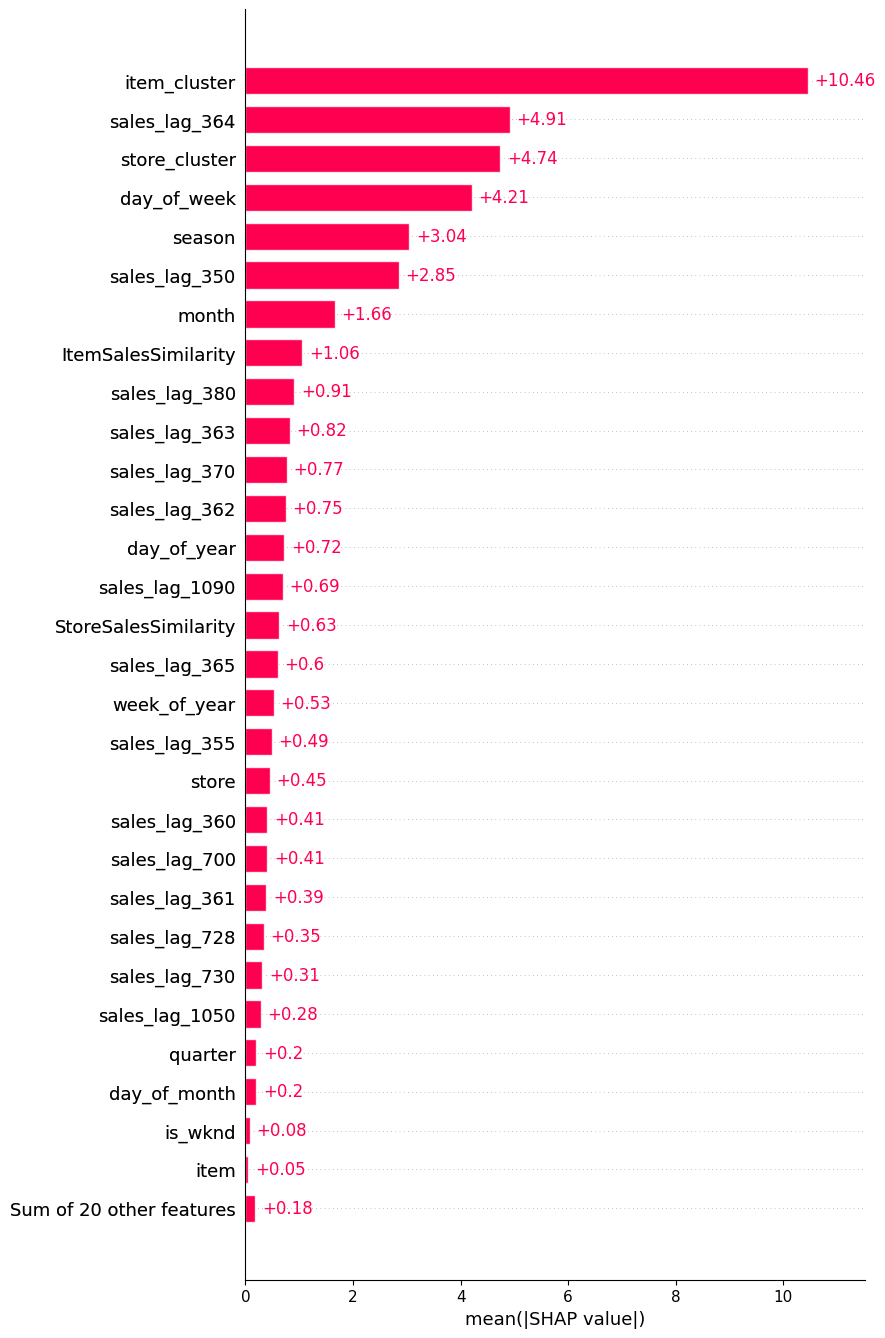

In [76]:
shap.plots.bar(shap_values_train, max_display=30)

# Second Model

### Default Parameters & Feature Selection with LGBM Feature Importance

In [77]:
# First model feature importance
cols = feature_imp_df[feature_imp_df.gain > 0.015].feature.tolist()
print("Independent Variables:", len(cols))

second_model = lgb.LGBMRegressor(random_state=384, num_leaves=31, n_estimators=1000, max_depth=10, metric = "custom").fit(
    X_train[cols], Y_train, 
    eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

print("TRAIN SMAPE:", smape(Y_train, second_model.predict(X_train[cols])))
print("VALID SMAPE:", smape(Y_val, second_model.predict(X_val[cols])))

Independent Variables: 27
TRAIN SMAPE: 12.53827190474565
VALID SMAPE: 12.475439253738449


**First Model Scores**

- TRAIN SMAPE: 12.6194
- VALID SMAPE: 12.5311
- 53 Features

**Second Model Scores**
- TRAIN SMAPE: 12.5382
- VALID SMAPE: 12.4754
- 27 Features

# Hyperparameter Tuning

There are two steps to tune LGBM models!

- **1st Optimization:** Randomized search CV for best learning rate
- **2nd Optimization:** Finding best iteration number by using early stopping round

**Hyperparameter tuning takes too long because of high iteration number and data dimension, that's why I add the Random Search CV algorithm below as text.**

In [78]:
# Define the parameter grid for randomized search
param_grid = {
    # 'num_leaves': [15, 31, 63],
    # 'n_estimators': [50, 100, 500, 1000, 2500],
    # 'max_depth': [10, 20, 30],
    "learning_rate": [0.01,0.20]
}

# Initialize the RandomizedSearchCV object
lgbm_random_cv = RandomizedSearchCV(second_model, param_grid, n_jobs=-1, n_iter=2, cv=2, random_state=384, 
                                     scoring=make_scorer(smape, greater_is_better=False))

# Fit the randomized search model
lgbm_random_cv.fit(X_train[cols], Y_train, 
                   eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)],
                   eval_set = [(X_train[cols], Y_train), (X_val[cols], Y_val)],
                   eval_names = ["Train", "Valid"],
                   early_stopping_rounds= 500, verbose = 100)

# Get the best hyperparameters
print("Best hyperparameters:", lgbm_random_cv.best_params_)


[100]	Train's SMAPE: 12.9704	Valid's SMAPE: 12.844
[200]	Train's SMAPE: 12.8029	Valid's SMAPE: 12.6646
[300]	Train's SMAPE: 12.7144	Valid's SMAPE: 12.5791
[400]	Train's SMAPE: 12.6463	Valid's SMAPE: 12.5328
[500]	Train's SMAPE: 12.5904	Valid's SMAPE: 12.5105
[600]	Train's SMAPE: 12.5369	Valid's SMAPE: 12.4918
[700]	Train's SMAPE: 12.4893	Valid's SMAPE: 12.4867
[800]	Train's SMAPE: 12.4427	Valid's SMAPE: 12.4855
[900]	Train's SMAPE: 12.4	Valid's SMAPE: 12.4811
[1000]	Train's SMAPE: 12.3573	Valid's SMAPE: 12.4822
Best hyperparameters: {'learning_rate': 0.2}


**First Model Scores**

- TRAIN SMAPE: 12.6194
- VALID SMAPE: 12.5311
- 53 Features
- Default Parameters

**Second Model Scores**
- TRAIN SMAPE: 12.5382
- VALID SMAPE: 12.4754
- 27 Features
- Default Parameters


**Third Model Scores**

- Best learning rate: 0.2



#### Second Optimization: Find best iteration number

In [79]:
# Best Params: {'num_leaves': 31, 'n_estimators': 15000, 'max_depth': 20}
# model_tuned2 = lgb.LGBMRegressor(**rsearch.best_params_, random_state=384, metric = "custom")

model_tuned2 = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.2, n_estimators=15000, max_depth=20, random_state=384, metric = "custom")
              
model_tuned2.fit(
    X_train[cols], Y_train,
    eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)],
    eval_set = [(X_train[cols], Y_train), (X_val[cols], Y_val)],
    eval_names = ["Train", "Valid"],
    early_stopping_rounds= 1000, verbose = 500
)
print("Best Iteration:", model_tuned2.booster_.best_iteration)

[500]	Train's SMAPE: 12.5812	Valid's SMAPE: 12.5041
[1000]	Train's SMAPE: 12.346	Valid's SMAPE: 12.4815
[1500]	Train's SMAPE: 12.1391	Valid's SMAPE: 12.503
Best Iteration: 809


**First Model Scores**

- TRAIN SMAPE: 12.6194
- VALID SMAPE: 12.5311
- 53 Features
- Default Parameters

**Second Model Scores**
- TRAIN SMAPE: 12.5382
- VALID SMAPE: 12.4754
- 27 Features
- Default Parameters


**1st Optimization Findings**

- Best learning rate: 0.2

**2nd Optimization Findings**
- Best iteration number: 809

# Final Model

In [80]:
df.sort_values(["store", "item", "date"], inplace = True)

train_final = df.loc[(df["date"] < "2018-01-01"), :]
test_final = df.loc[(df["date"] >= "2018-01-01"), :]

X_train_final = train_final[cols]
Y_train_final = train_final.sales
X_test_final = test_final[cols]


#final_model = lgb.LGBMRegressor(**rsearch.best_params_, random_state=384, metric = "custom") # Tuned parameters
# Best Params: {'num_leaves': 31, 'n_estimators': 15000, 'max_depth': 20}
final_model = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.2, n_estimators=15000, max_depth=20, random_state=384, metric = "custom")
final_model.set_params(n_estimators=model_tuned2.booster_.best_iteration) 
final_model.fit(X_train_final[cols], Y_train_final,
                eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])
                
print("TRAIN SMAPE:", smape(Y_train, final_model.predict(X_train[cols])))
print("VALID SMAPE:", smape(Y_val, final_model.predict(X_val[cols])))                

TRAIN SMAPE: 12.451599994637245
VALID SMAPE: 11.960517748782443


**First Model Scores**

- TRAIN SMAPE: 12.6194
- VALID SMAPE: 12.5311
- 53 Features
- Default Parameters

**Second Model Scores**
- TRAIN SMAPE: 12.5382
- VALID SMAPE: 12.4754
- 27 Features
- Default Parameters

**1st Optimization Findings**

- Best learning rate: 0.2

**2nd Optimization Findings**
- Best iteration number: 809

**Final Model Scores**
- TRAIN SMAPE: 12.4516
- VALID SMAPE: 11.9605
- 27 Features
- Best learning rate: 0.2
- Best iteration number: 809

# Submission

In [84]:
import pickle
pickle.dump(final_model, open("final_model.pkl", "wb"))

In [85]:
submission = pd.DataFrame({
    "id":test_final.id.astype(int),
    "sales":final_model.predict(X_test_final)
})
submission.to_csv("submission.csv", index = None)

In [86]:
submission[["sales"]].describe([0.1, 0.75, 0.8, 0.9, 0.95, 0.99]).T

,count,mean,std,min,10%,50%,75%,80%,90%,95%,99%,max
sales,45000.0,46.840383,23.490082,7.270396,19.205904,43.417755,62.01819,66.912513,79.781096,90.533472,110.498127,147.787378


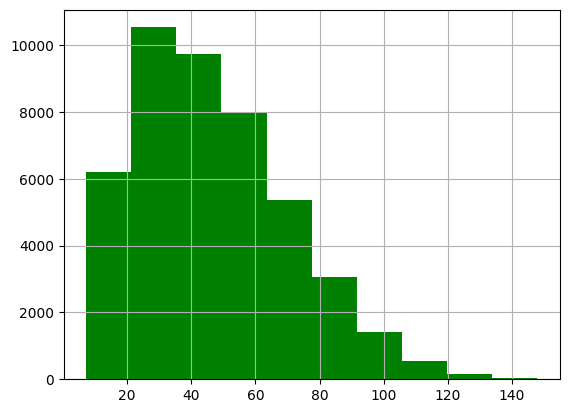

In [87]:
submission.sales.hist(color = "g");

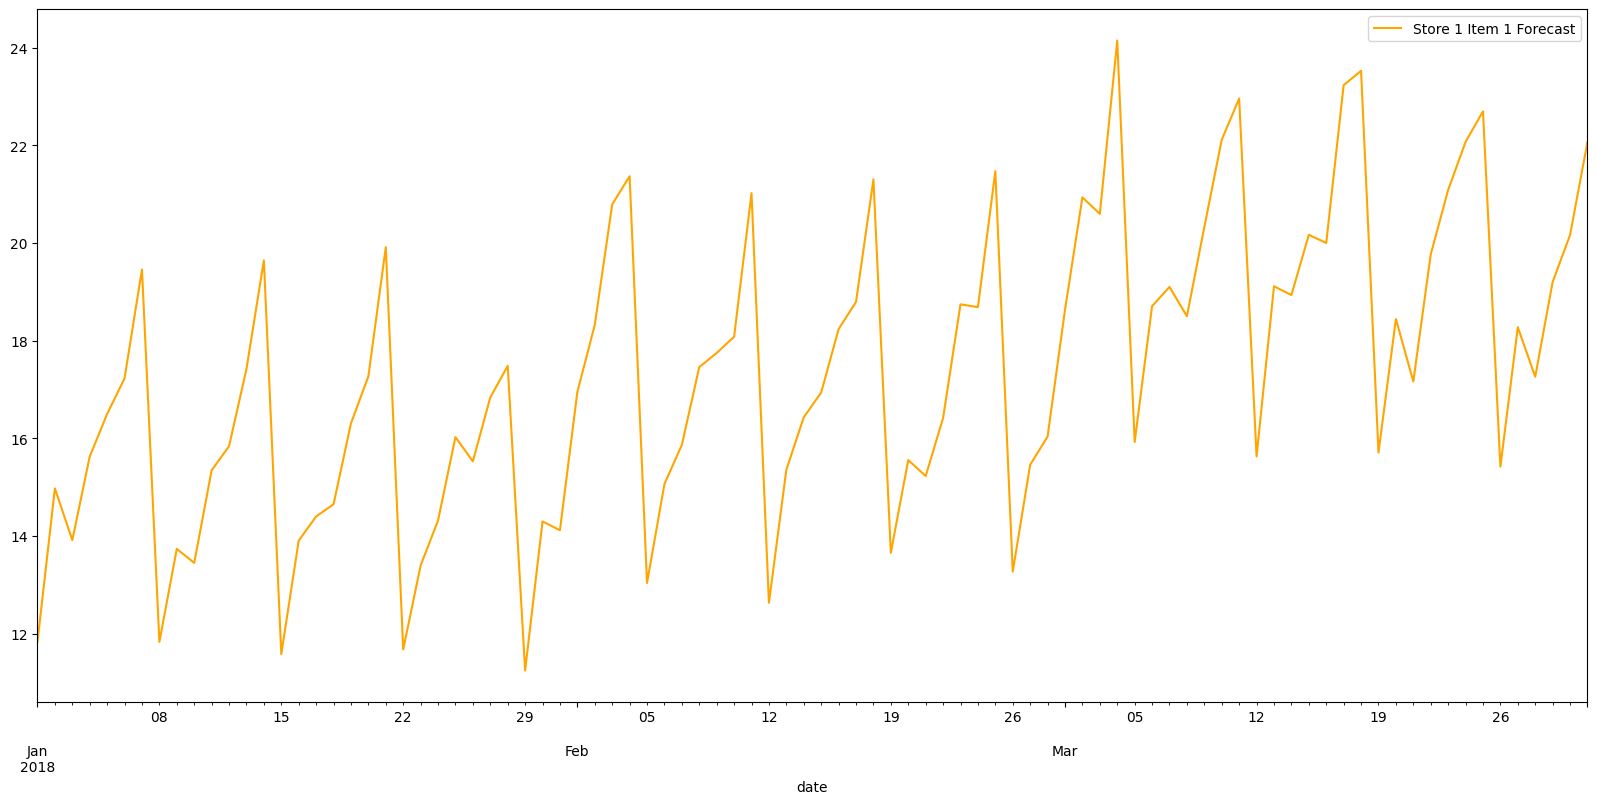

In [88]:
forecast = pd.DataFrame({
    "date":test_final.date,
    "store":test_final.store,
    "item":test_final.item,
    "sales":final_model.predict(X_test_final)
})

forecast[(forecast.store == 1) & (forecast.item == 1)].set_index("date").sales.plot(color = "orange", figsize = (20,9),legend=True, label = "Store 1 Item 1 Forecast");

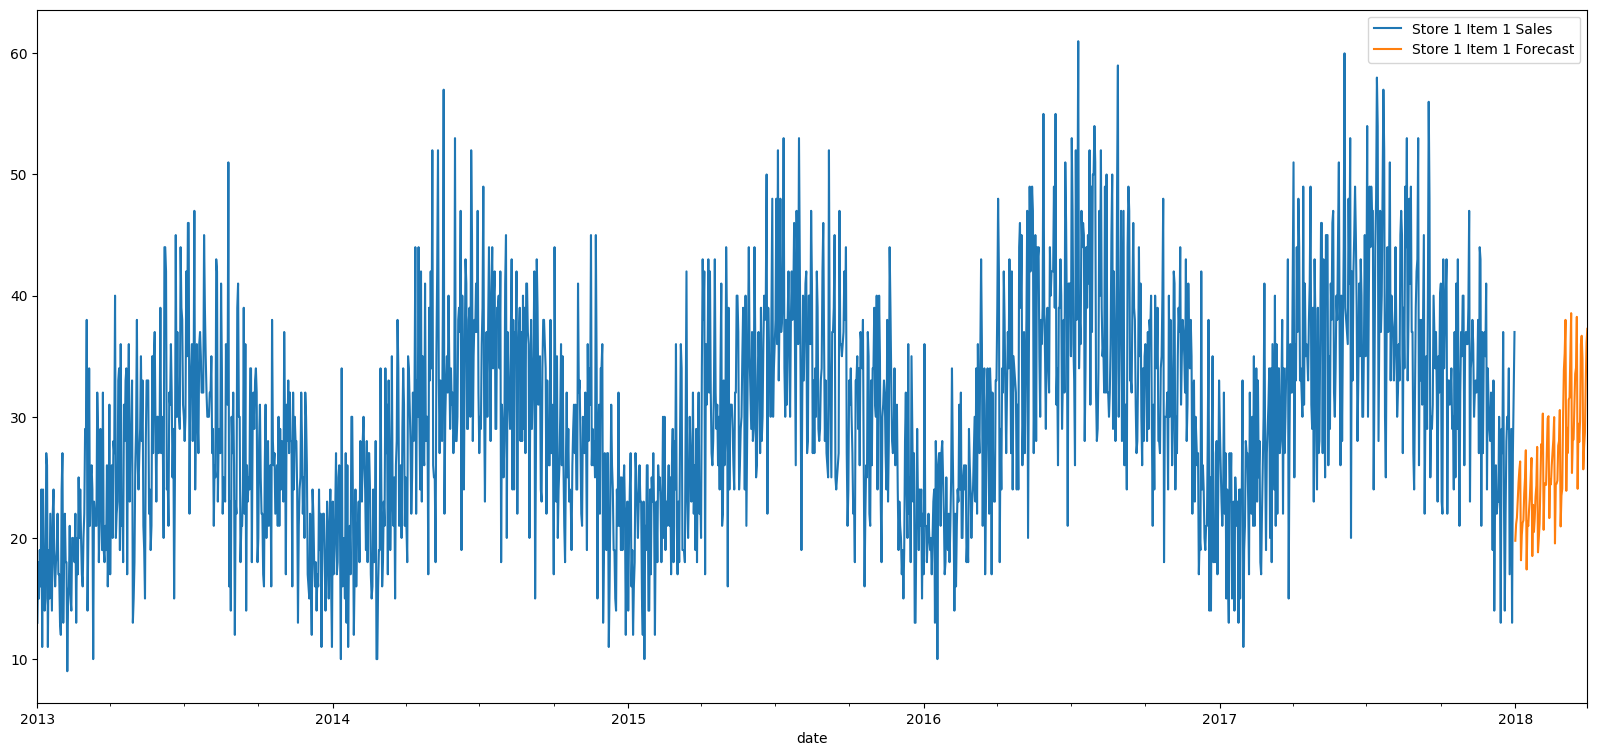

In [89]:
train_final[(train_final.store == 1) & (train_final.item == 17)].set_index("date").sales.plot(figsize = (20,9),legend=True, label = "Store 1 Item 1 Sales")
forecast[(forecast.store == 1) & (forecast.item == 17)].set_index("date").sales.plot(legend=True, label = "Store 1 Item 1 Forecast");

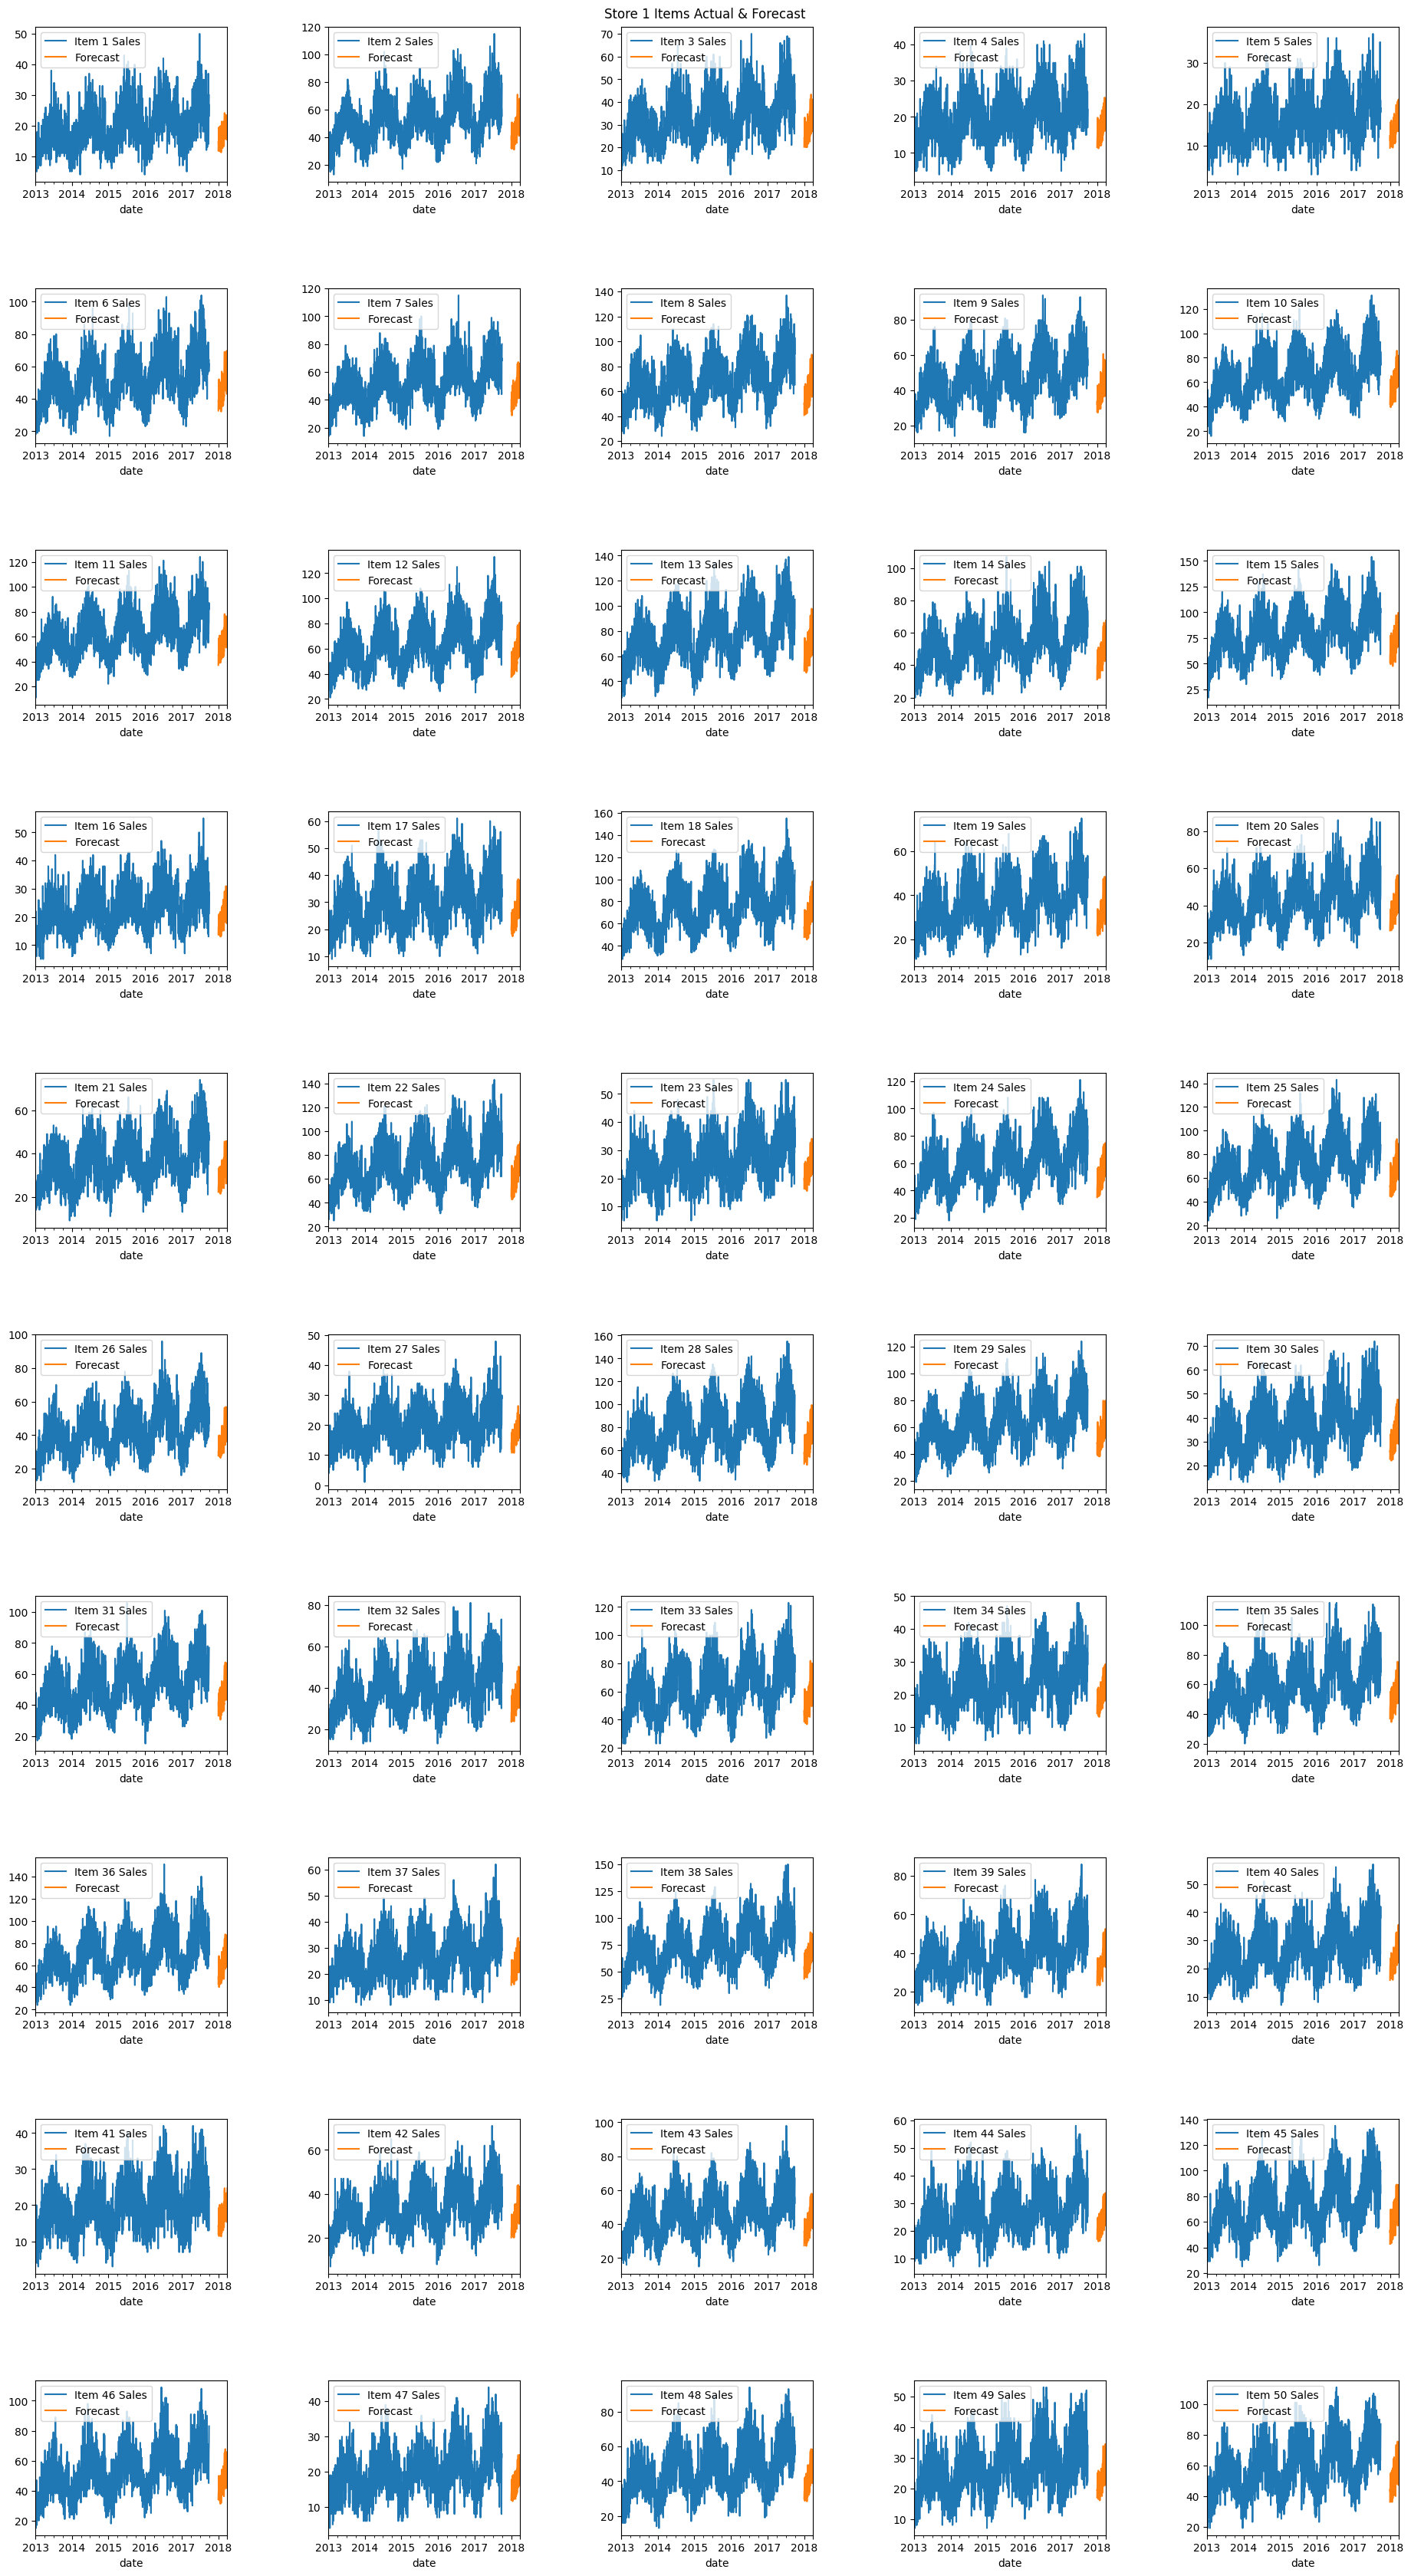

In [90]:
store = 1
sub = train[train.store == store].set_index("date")
forc = forecast[forecast.store == store].set_index("date")


fig, axes = plt.subplots(10, 5, figsize=(20, 35))
for i in range(1,51):
    if i < 6:
        sub[sub.item == i].sales.plot(ax=axes[0, i-1], legend=True, label = "Item "+str(i)+" Sales")
        forc[forc.item == i].sales.plot(ax=axes[0, i-1], legend=True, label = "Forecast")
    if i >= 6 and i<11:
        sub[sub.item == i].sales.plot(ax=axes[1, i - 6], legend=True, label = "Item "+str(i)+" Sales")
        forc[forc.item == i].sales.plot(ax=axes[1, i-6], legend=True, label = "Forecast")
    if i >= 11 and i<16:
        sub[sub.item == i].sales.plot(ax=axes[2, i - 11], legend=True, label = "Item "+str(i)+" Sales") 
        forc[forc.item == i].sales.plot(ax=axes[2, i-11], legend=True, label = "Forecast")
    if i >= 16 and i<21:
        sub[sub.item == i].sales.plot(ax=axes[3, i - 16], legend=True, label = "Item "+str(i)+" Sales")    
        forc[forc.item == i].sales.plot(ax=axes[3, i-16], legend=True, label = "Forecast")
    if i >= 21 and i<26:
        sub[sub.item == i].sales.plot(ax=axes[4, i - 21], legend=True, label = "Item "+str(i)+" Sales") 
        forc[forc.item == i].sales.plot(ax=axes[4, i-21], legend=True, label = "Forecast")
    if i >= 26 and i<31:
        sub[sub.item == i].sales.plot(ax=axes[5, i - 26], legend=True, label = "Item "+str(i)+" Sales")
        forc[forc.item == i].sales.plot(ax=axes[5, i-26], legend=True, label = "Forecast")
    if i >= 31 and i<36:
        sub[sub.item == i].sales.plot(ax=axes[6, i - 31], legend=True, label = "Item "+str(i)+" Sales")  
        forc[forc.item == i].sales.plot(ax=axes[6, i-31], legend=True, label = "Forecast")
    if i >= 36 and i<41:
        sub[sub.item == i].sales.plot(ax=axes[7, i - 36], legend=True, label = "Item "+str(i)+" Sales")
        forc[forc.item == i].sales.plot(ax=axes[7, i-36], legend=True, label = "Forecast")
    if i >= 41 and i<46:
        sub[sub.item == i].sales.plot(ax=axes[8, i - 41], legend=True, label = "Item "+str(i)+" Sales") 
        forc[forc.item == i].sales.plot(ax=axes[8, i-41], legend=True, label = "Forecast")
    if i >= 46 and i<51:
        sub[sub.item == i].sales.plot(ax=axes[9, i - 46], legend=True, label = "Item "+str(i)+" Sales") 
        forc[forc.item == i].sales.plot(ax=axes[9, i-46], legend=True, label = "Forecast")
plt.tight_layout(pad=6.5)
plt.suptitle("Store 1 Items Actual & Forecast");